In [1]:
# importing the packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [2]:
# reading the values of camera calibration
dist_pickle = pickle.load(open("./camera_cal/calibration_pickle.p", 'rb'))
mtx = dist_pickle["mtx"]
dist = dist_pickle['dist']


### Writing Functions..

In [3]:
# Define a function that applies Sobel x or y, then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # convert the image into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # find the gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Scale to 8-bit (0 - 255) then convert to type =
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

# Define a function that applies Sobel x and y, then computes the magnitude of the gradient and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # convert the image into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # find the gradient
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    mag_sobel = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    # Scale to 8-bit (0 - 255) then convert to type =
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Apply threshold
    return mag_binary

# Define a function that applies Sobel x and y, then computes the direction of the gradient and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # convert the image into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # find the gradient
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # find the direction
    abs_graddir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    dir_binary = np.zeros_like(abs_graddir)
    dir_binary[(abs_graddir >= thresh[0]) & (abs_graddir <= thresh[1])] = 1

    # Apply threshold
    return dir_binary

# Define a function that thresholds the S-channel of HLS
def hls_threshold(img, thresh=(0, 255)):
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # Return a binary image of threshold result
    return binary_output


In [ ]:
# Note: image.shape :: [y,x,channel]

## Pipeline

### 1. Provide an example of a distortion-corrected image.

In [4]:
# reading the one test image
img_1 = mpimg.imread('test_images/test1.jpg')

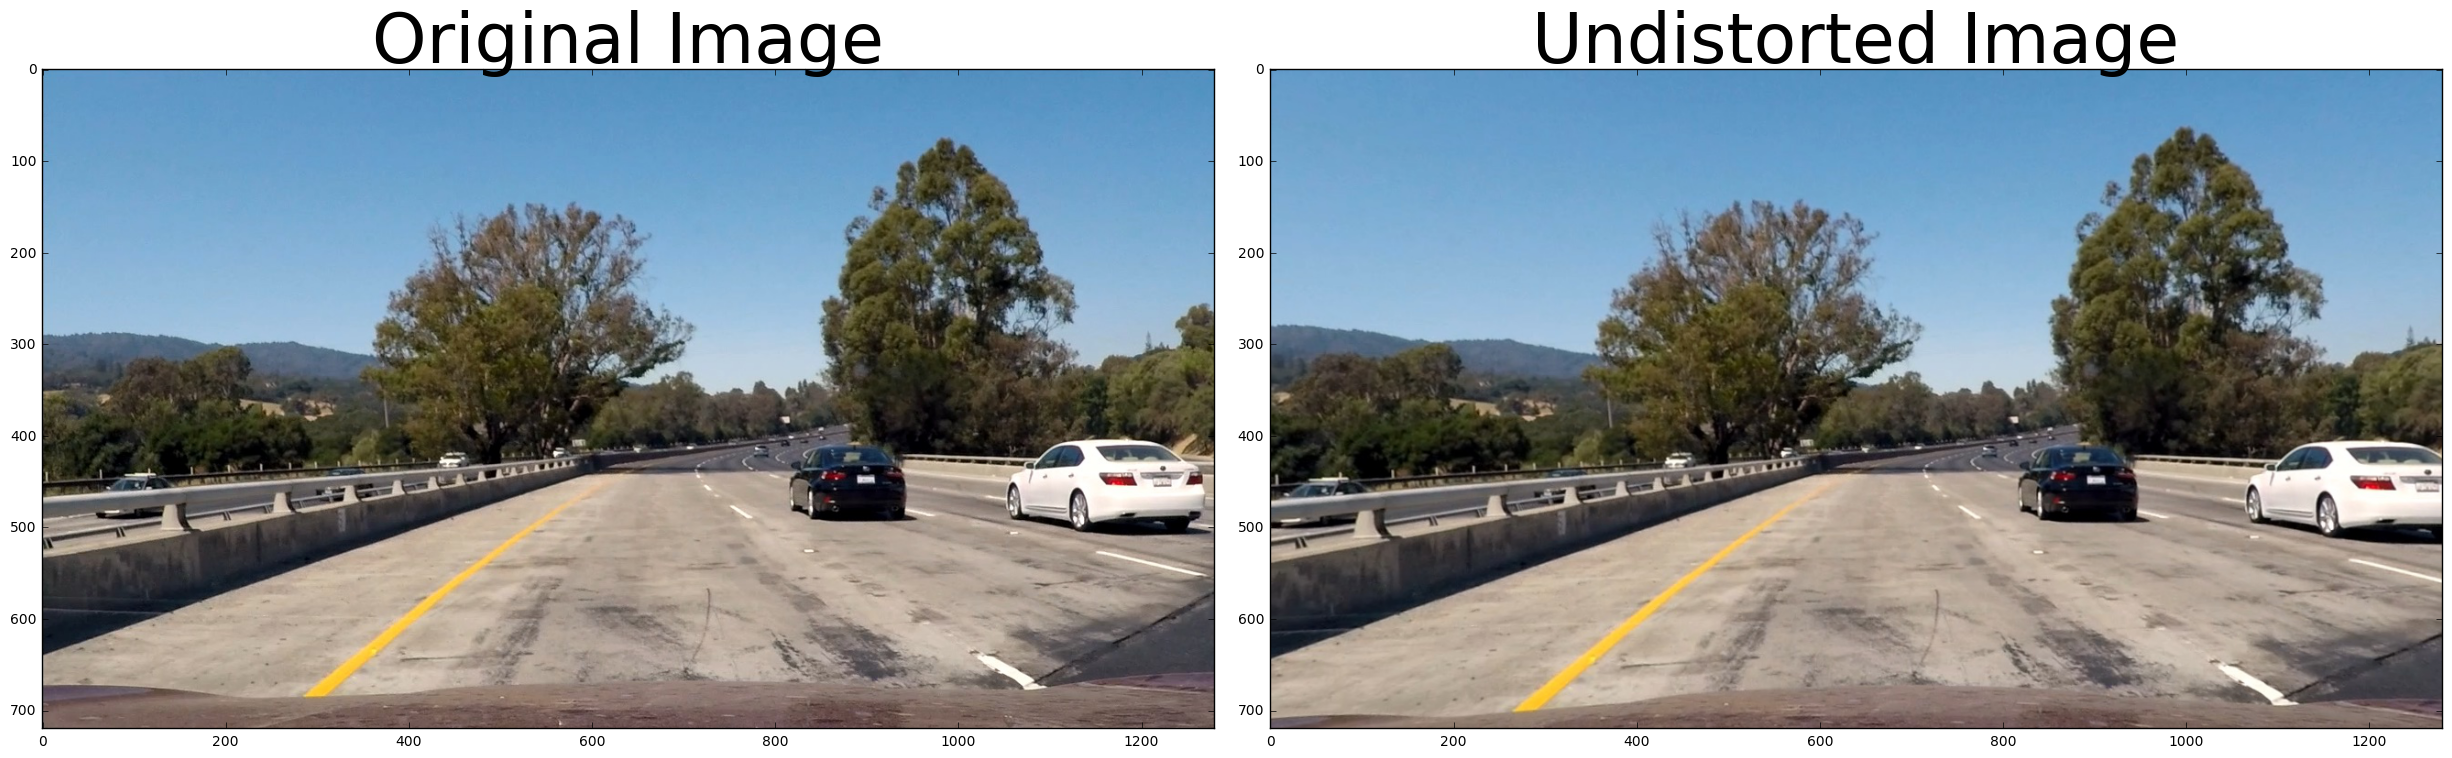

In [5]:
# undistorting a test image
img = cv2.undistort(img_1, mtx, dist, None, mtx)

# show one image for testing
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

In [6]:
ksize = 15
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 200))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 200))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 200))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
color_binary = hls_threshold(img, thresh = (90,255))

In [7]:
def pipeline_thresh(image, s_thresh = (0, 255), x_thresh =(0,255), y_thresh=(0,255)):
    # sobel kernel
    ksize = 15
    # threshold using sobel x and sobel y
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=x_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=y_thresh)
    # threshold using hls color scale
    s_binary = hls_threshold(image, thresh=s_thresh)
    
    # combining x and y
    combined_binary = np.zeros_like(gradx)
    combined_binary[((gradx == 1) & (grady == 1)) | (s_binary==1)] = 1

    return combined_binary

In [8]:
# Combining the color and x, y thresholds
combine_result = pipeline_thresh(img, s_thresh= (90,255), x_thresh=(10,200), y_thresh=(20,200))

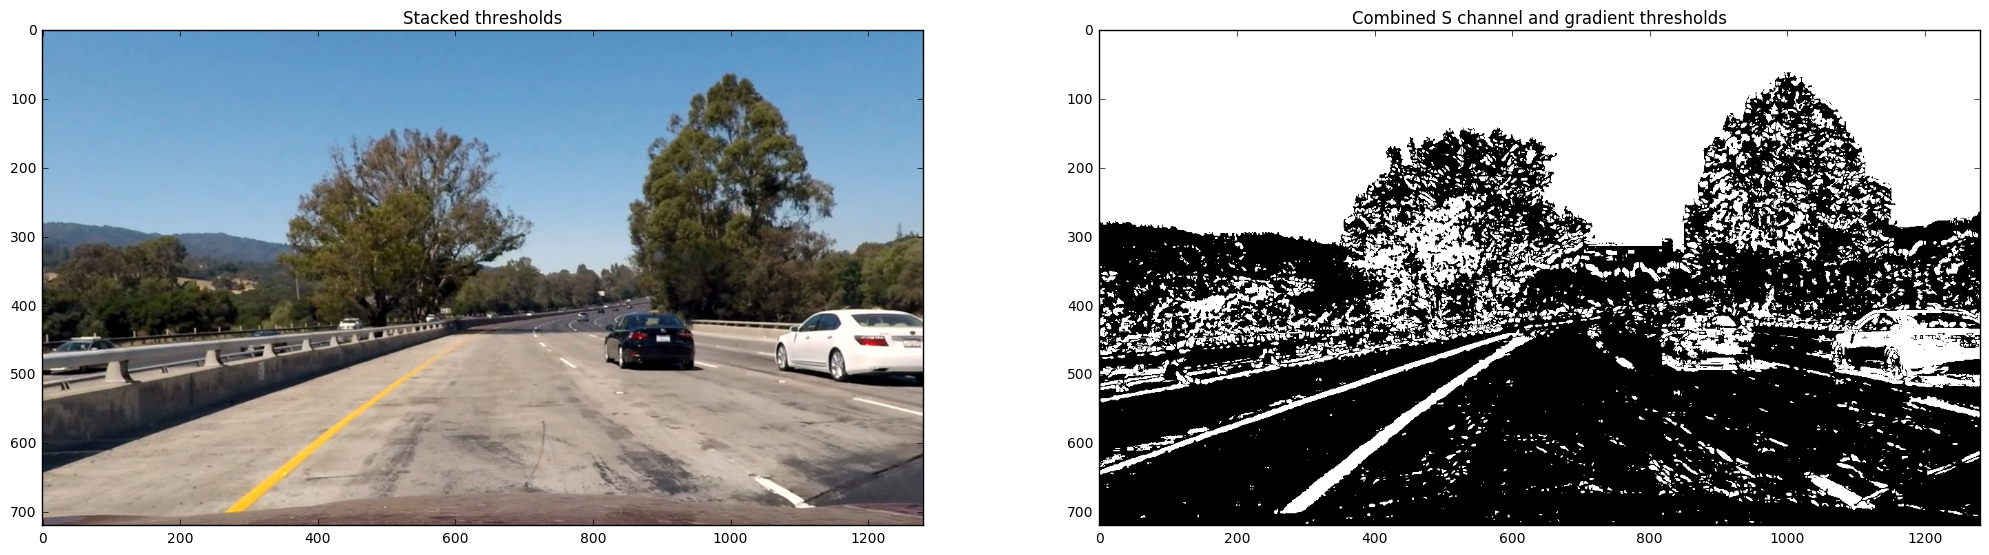

In [9]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))

ax1.set_title('Stacked thresholds')
ax1.imshow(img)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combine_result, cmap='gray')

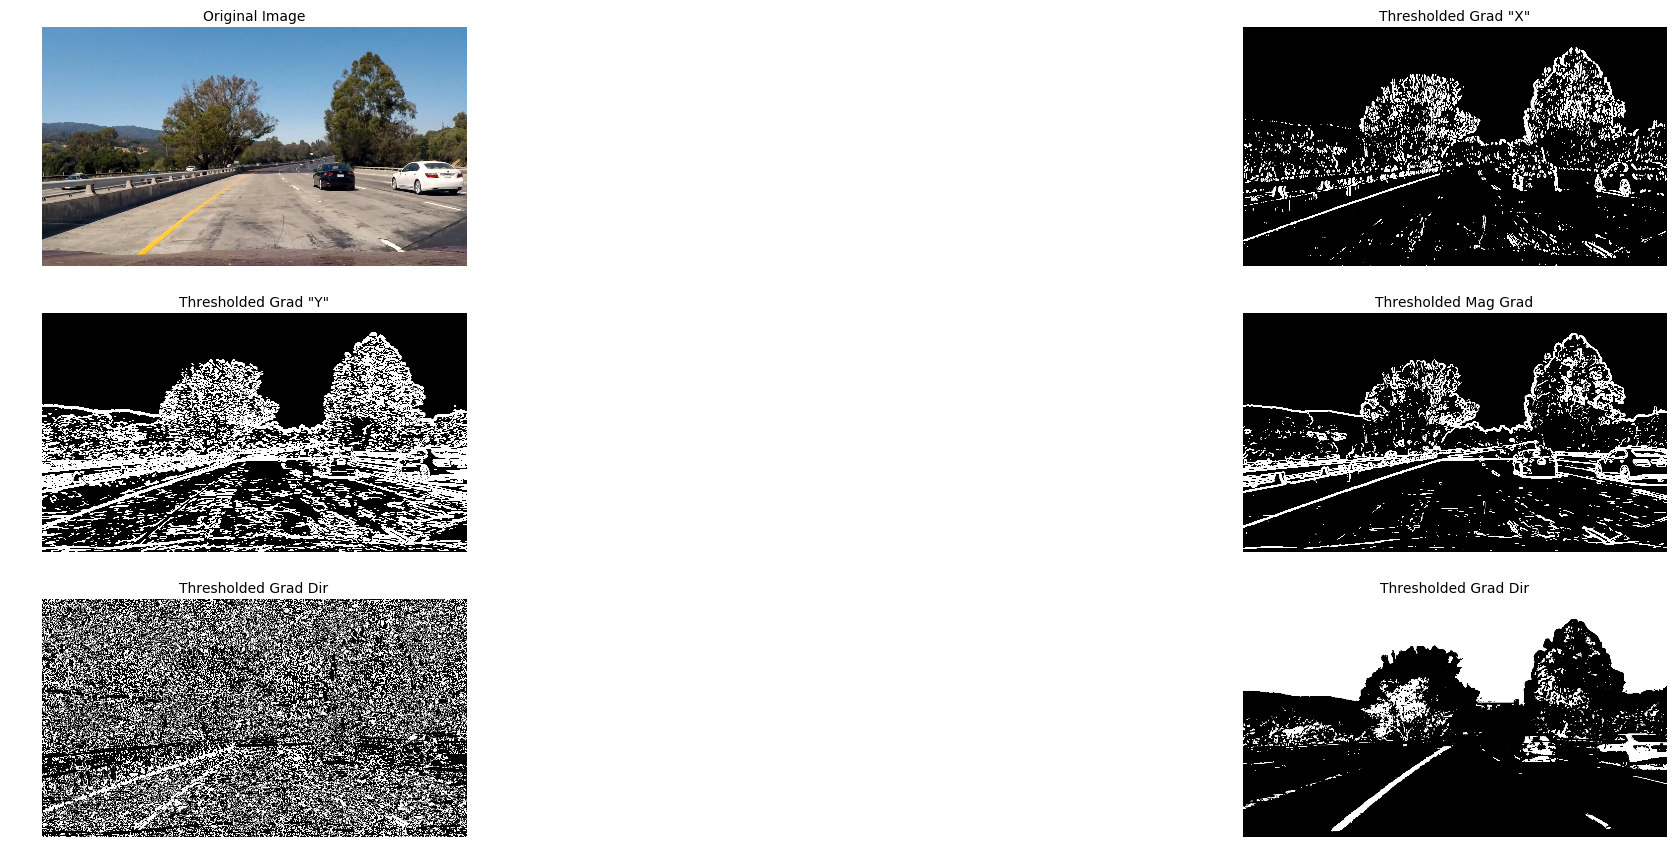

In [10]:
# show the images
# Plot the result
fig, axs = plt.subplots(3,2, figsize=(24, 9))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].axis("off")
axs[0].imshow(img_1)
axs[0].set_title('Original Image', fontsize=10)

axs[1].axis("off")
axs[1].imshow(gradx, cmap='gray')
axs[1].set_title('Thresholded Grad "X"', fontsize=10)

axs[2].axis("off")
axs[2].imshow(grady, cmap='gray')
axs[2].set_title('Thresholded Grad "Y"', fontsize=10)

axs[3].axis("off")
axs[3].imshow(mag_binary, cmap='gray')
axs[3].set_title('Thresholded Mag Grad', fontsize=10)

axs[4].axis("off")
axs[4].imshow(dir_binary, cmap='gray')
axs[4].set_title('Thresholded Grad Dir', fontsize=10)

axs[5].axis("off")
axs[5].imshow(color_binary, cmap='gray')
axs[5].set_title('Thresholded Grad Dir', fontsize=10)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

In [58]:
# To perform a perspective transformation I need to find 4 points that make trazepoid, so that it covers the lane lines
# and then define 4 destination point to bird's eye view

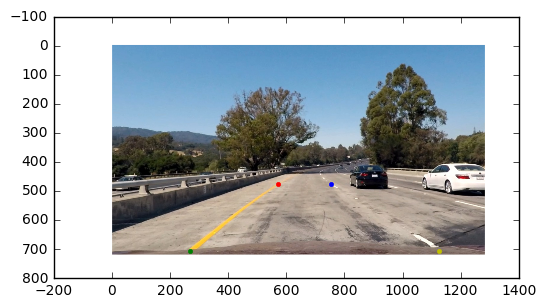

In [115]:
# Finding 4 source points 
plt.imshow(img)
plt.plot(570,475,'.',c='r')
plt.plot(755,475,'.',c='b')
plt.plot(270,705,'.',c='g')
plt.plot(1125,705,'.',c='y')

#565,475;  760, 475; 280, 760; 1115,760

In [116]:
# Image and transformed image coordinates
src = np.float32([[570,475], [270, 705], [1125,705], [755, 475]])
dst = np.float32([[320, 0], [320, 705], [960, 705], [960, 0]])

In [13]:
def warp(image, src, dst):
    # images size
    img_size = (image.shape[1], image.shape[0])
    # takes in the source and destination points and returns the mapping as a perpective matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # inverse perpective transform
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    # takes in the image, perspective matrix and size of image, 
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, M_inv


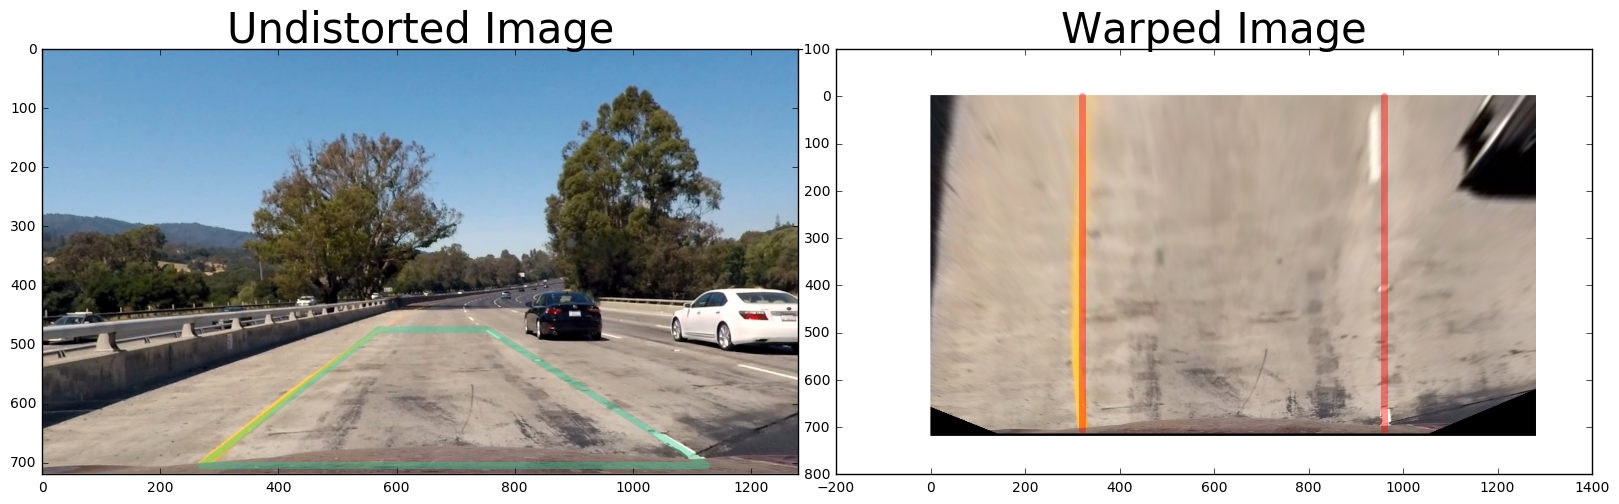

In [117]:
warped_image, M, M_inv = warp(img, src, dst) # here input image i.e. "img" is the undistorted images used in cell 5

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(img)
x = [[570], [270], [1125], [755], [570]]
y = [[475], [705], [705], [475], [475]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)
ax1.set_ylim([img.shape[0],0])
ax1.set_xlim([0,img.shape[1]])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped_image)
x = [[320], [320]]
x1 = [[960],[960]]
y = [[0], [705]]
ax2.plot(x, y, color='red', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)
ax2.plot(x1, y, color='red', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)
ax2.set_title('Warped Image', fontsize=30)


### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

In [15]:
# reading all the images
images = glob.glob('./test_images/test*.jpg')

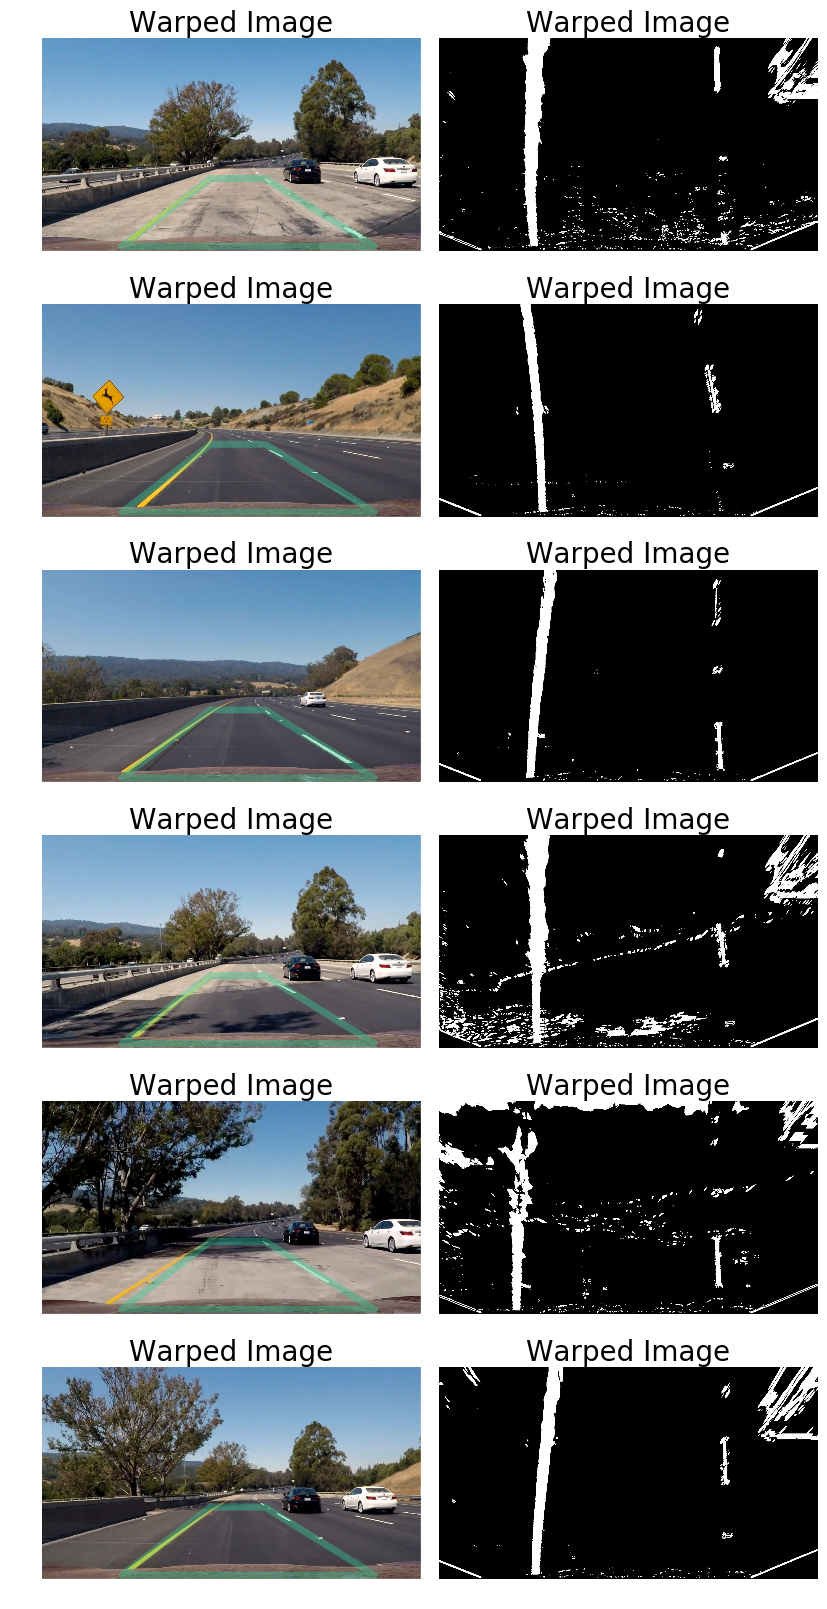

In [118]:
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()

# creating a pipeline to undistort, unwarp and find threshold, transform and then visualize all images
idx = 0
for fname in images:
    # step 1: read the images
    read_img = mpimg.imread(fname)
    # step 2: undistort the image
    img_undist = cv2.undistort(read_img, mtx, dist, None, mtx)
    # step 2: Unwarp the image
    img_unwarp, M, Minv = warp(img_undist, src, dst)
    # step 2: thresholded image, using HLS color and X and Y gradient
    img_thresh = pipeline_thresh(img_unwarp, s_thresh= (90,255), x_thresh=(10,200), y_thresh=(20,200))
    
    axs[idx].imshow(read_img)
    axs[idx].axis('off')
    x = [[570], [270], [1125], [755], [570]]
    y = [[475], [705], [705], [475], [475]]
    axs[idx].plot(x, y, color='#33cc99', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)
    axs[idx].set_ylim([img.shape[0],0])
    axs[idx].set_xlim([0,img.shape[1]])
    axs[idx].set_title('Warped Image', fontsize=20)
    idx += 1
    axs[idx].imshow(img_thresh, cmap='gray')
    axs[idx].axis('off')
    axs[idx].set_title('Warped Image', fontsize=20)
    idx += 1

In [119]:
# Function to fit polynomial to binary image with lines extracted, using sliding window

def sliding_window_fit(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # After bisecting the image into two halves, find the peak of the left and right halves of the histogram
    # midpoint of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    
    quarter_point = np.int(midpoint//2)
    # Rather than using the max of left and right half of the histogram, only a quarter of the histogram 
    # (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows, (i.e the number of windows/square(on each lane) present on the image)
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_ = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    box_hist_data = (rectangle_, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, box_hist_data

### Note- Using 'test6.jpg' or the last warped image in the above analysis for visualization

(720, 0)

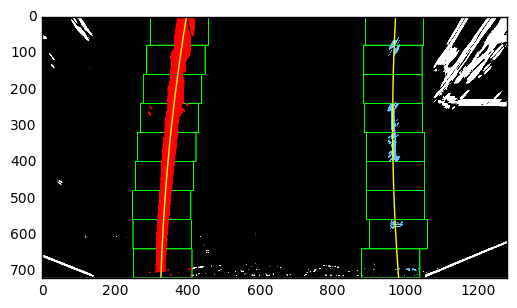

In [139]:
# Draw the rectangle windows on the binary wraped image

# The input image i.e. "img_thresh" is the image after step 4(i.e. read, undistort, wrap, threshold)
# step 5:
left_fit, right_fit, left_lane_inds, right_lane_inds, box_hist_data = sliding_window_fit(img_thresh)

# height of the actual images , here "read_img" is the test_image6
h = read_img.shape[0]
# fitting the left and right polynomial to height to find the final point
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

# all rectangle and their associated histograms
rectangles = box_hist_data[0]
histogram = box_hist_data[1]

# Create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((img_thresh, img_thresh, img_thresh))*255)

# Generate x and y values for plotting
ploty = np.linspace(0, img_thresh.shape[0]-1, img_thresh.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

# Identify the x and y positions of all nonzero pixels in the image
nonzero = img_thresh.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Plotting the Histogram

(0, 1280)

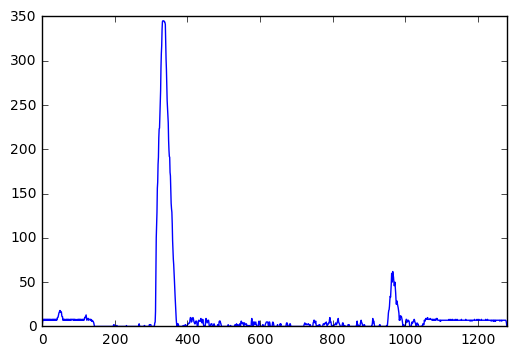

In [121]:
plt.plot(histogram)
plt.xlim(0, 1280)

#### Once we know the sliding window we do not need to repeat it for next images, as we know where the lines are

**NOTE:** images test6, test4, test1 and test5 appears to taken one after the other on the same road and conditions. so, they can be used as continous images for testing before modifying the code for video(which can be considered as just a set of continous images taken one after another)

In [145]:
# Function to fit the polynomial on chronological images, assuming that the lanes do not change drastically
# the input image is a binary thresholded image obtained after step 4
def Fit_using_prev_img(thresholded_img, prev_left_fit, prev_right_fit):
    
    nonzero = thresholded_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 90
    
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                                   prev_left_fit[2] - margin)) & 
                      (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                                   prev_left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                                    prev_right_fit[2] - margin)) & 
                       (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                                    prev_right_fit[2] + margin)))
    
    # Again, as previous done, extract new left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


### Lets visualize the results on an example image

...


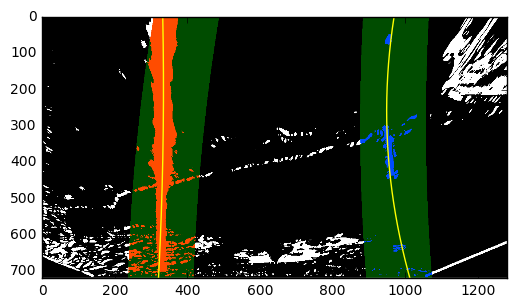

In [146]:
# as the left_fit and right_fit are taken from test_img6 using in sliding_window_fit function, I will use the 
# chronologically next image i.e. test5

# all steps from 1 to 4
original_img = mpimg.imread('./test_images/test4.jpg')
img_undistort = cv2.undistort(original_img, mtx, dist, None, mtx)
img_unwarp, M, Minv = warp(img_undistort, src, dst)
img_threshold = pipeline_thresh(img_unwarp, s_thresh= (90,255), x_thresh=(10,200), y_thresh=(20,200))
margin = 90

# step 5:
left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = Fit_using_prev_img(img_threshold, 
                                                                                              left_fit, right_fit)

# Generate x and y values for plotting, as done previously 
ploty = np.linspace(0, img_threshold.shape[0]-1, img_threshold.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

left_fitx2 = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx2 = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((img_threshold, img_threshold, img_threshold))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = img_threshold.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds_new], nonzerox[left_lane_inds_new]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_new], nonzerox[right_lane_inds_new]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (i.e. previous fit)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print('...')

### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [124]:
# function to calculate Radius of Curvature and center distance
# using data from above function 
def curvature_rad_center_dist(binary_wraped_image, left_fit, right_fit, left_lane_idx, right_lane_idx):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    
    # create variable to store the values
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    # the maximum y-value, corresponding to the bottom of the image
    h = binary_wraped_image.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_val = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_wraped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_idx]
    lefty = nonzeroy[left_lane_idx] 
    rightx = nonzerox[right_lane_idx]
    righty = nonzeroy[right_lane_idx]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_val*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_val*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
    if left_fit is not None and right_fit is not None:
        center_ofimage = binary_wraped_image.shape[1]/2
        left_fit_x = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        
        lane_center_position = (right_fit_x + left_fit_x)/2
        center_dist = (center_ofimage - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist


In [125]:
# step 6:
# the input image i.e. "out_img", is the image created by using the values obtained from the sliding window function
left_radius, right_radius, dist_fromcenter = curvature_rad_center_dist(out_img, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for test image (in meters):', 'left:', left_radius, '; right:',right_radius)
print('Distance from lane center for test image (in meters):', dist_fromcenter, 'm')


Radius of curvature for test image (in meters): left: 1464.93889881 ; right: 416.04420905
Distance from lane center for test image (in meters): -0.138277794543 m


### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

First draw the polynomial on the lanes and then add the required radius and lane center data

In [126]:

# Function to draw the polynomial on the lanes
def color_driving_lane(original_image, thresh_image, left_fit, right_fit, Minv):
    
    image = np.copy(original_image)
    if left_fit is None or right_fit is None:
        return original_image
    # color on the sliding 
    warp_zero = np.zeros_like(thresh_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # images size
    img_size = (thresh_image.shape[1], thresh_image.shape[0])
    
    ploty = np.linspace(0, img_size[0]-1, num=img_size[0]) # to cover same y-range as image
    # fit the polynomial
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,105), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,105,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    warped_img = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, warped_img, 0.5, 0)
    
    return result

### Coloring the travelling lane (entire pipeline)

#### Testing all the values on a new image.....

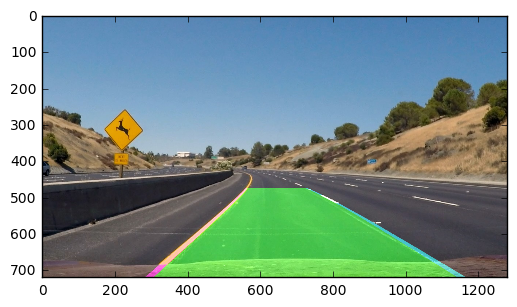

In [127]:
# step 1: read the images
original_img = mpimg.imread('./test_images/test2.jpg')
# step 2: undistort the image
img_undistort = cv2.undistort(original_img, mtx, dist, None, mtx)
# step 3: Unwarp the image
img_unwarp, M, Minv = warp(img_undistort, src, dst)
# step 4: thresholded image, using HLS color and X and Y gradient
img_threshold = pipeline_thresh(img_unwarp, s_thresh= (90,255), x_thresh=(10,200), y_thresh=(20,200))
# step 5 : finding the sliding window dimensions
left_fit, right_fit, left_lane_inds, right_lane_inds, box_hist_data = sliding_window_fit(img_threshold)

# After performing all the above steps, colouring the space between the lanes
lanedrawn_img = color_driving_lane(original_img, img_threshold, left_fit, right_fit, Minv)
plt.imshow(lanedrawn_img)

In [128]:
# Find the radius and distance from the center and print in on the image

def plot_rad_dcenter(lanecolored_image, mean_curvature_rad, center_distance):
    
    image = np.copy(lanecolored_image)
    #h = new_img.shape[0]
    
    # display Curvature Radius details
    text = 'Radius of Curvature: ' + '{:04.2f}'.format(mean_curvature_rad) + '(m)'
    cv2.putText(image, text, (40,70), cv2.FONT_HERSHEY_DUPLEX, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    # deciding the direction
    direction = ''
    if center_distance > 0:
        direction = 'right'
    elif center_distance < 0:
        direction = 'left'
    
    abs_dist = abs(center_distance)
    text = '{:04.3f}'.format(abs_dist) + '(m) ' + direction + ' out of center'
    cv2.putText(image, text, (40,120), cv2.FONT_HERSHEY_DUPLEX, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return image


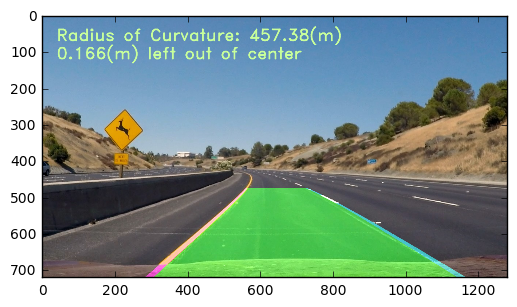

In [129]:
# step 6: finding the radius and distance from center
left_radius, right_radius, dist_fromcenter = curvature_rad_center_dist(img_threshold, left_fit, right_fit, left_lane_inds, right_lane_inds)

final_image = plot_rad_dcenter(lanedrawn_img, (left_radius + right_radius)/2, dist_fromcenter)
plt.imshow(final_image)

**Testing:** Based on the above image drawing a sliding windows on it......

(720, 0)

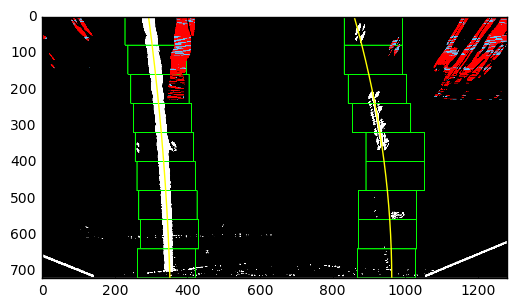

In [130]:

# height of the actual images , here "read_img" is the test_image6
h = original_img.shape[0]
# fitting the left and right polynomial to height to find the final point
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

# all rectangle and their associated histograms
rectangles = box_hist_data[0]
histogram = box_hist_data[1]

# Create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((img_threshold, img_threshold, img_threshold))*255)

# Generate x and y values for plotting
ploty = np.linspace(0, img_threshold.shape[0]-1, img_threshold.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

# Identify the x and y positions of all nonzero pixels in the image
nonzero = img_thresh.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



## Pipeline (video)

### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

In [131]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    
    # if we already have a detected line
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # Even, though its not the best fit, we accept unless there are no fits in the current_fit queue
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest 
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # remove the oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there exist more fit in the queue then take their average to find the best fit
                self.best_fit = np.average(self.current_fit, axis=0)

### Define complete image processing pipeline for videos

In [157]:
def process_images(image):
    # step 1: create a copy of the image
    new_img = np.copy(image)
    # step 2: undistort the image
    img_undistort = cv2.undistort(new_img, mtx, dist, None, mtx)
    # step 3: Unwarp the image
    warped_img, M, Minv = warp(img_undistort, src, dst)
    # step 4: thresholded image, using HLS color and X and Y gradient
    img_threshold = pipeline_thresh(warped_img, s_thresh= (90,255), x_thresh=(10,200), y_thresh=(20,200))
    
    # if both left and right lines were detected last frame, use Fit_using_prev_img, otherwise use sliding_window_fit
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds, box_hist_data = sliding_window_fit(img_threshold)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = Fit_using_prev_img(img_threshold, left_line.best_fit, 
                                                                                  right_line.best_fit)

    # invalidate both left and right fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    # as they do not represent lanes effectively
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        left_fit_x = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_diff = abs(right_fit_x - left_fit_x)
        if abs(350 - x_diff) > 100:
            left_fit = None
            right_fit = None
    
    left_line.add_fit(left_fit, left_lane_inds)
    right_line.add_fit(right_fit, right_lane_inds)
    
    # draw the current best fit(if it exists)
    if left_line.best_fit is not None and right_line.best_fit is not None:
        lane_col_img = color_driving_lane(new_img, img_threshold, left_line.best_fit, right_line.best_fit, Minv)
        left_radius, right_radius, dist_fromcenter = curvature_rad_center_dist(img_threshold, left_line.best_fit, 
                                                                               right_line.best_fit, left_lane_inds,
                                                                               right_lane_inds)
        img_out = plot_rad_dcenter(lane_col_img, (left_radius+right_radius)/2, dist_fromcenter)
    else:
        img_out = new_img
        

    return img_out 


        

Method for plotting a fit on a binary image - diagnostic purpose

In [163]:
left_line = Line()
right_line = Line()
#my_clip.write_gif('test.gif', fps=12)
proj_video_out = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_images)
%time processed_video.write_videofile(proj_video_out, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<05:02,  4.17it/s]


  0%|          | 2/1261 [00:00<05:18,  3.95it/s]


  0%|          | 3/1261 [00:00<04:43,  4.43it/s]


  0%|          | 4/1261 [00:00<04:34,  4.58it/s]


  0%|          | 5/1261 [00:01<04:23,  4.77it/s]


  0%|          | 6/1261 [00:01<04:18,  4.85it/s]


  1%|          | 7/1261 [00:01<04:05,  5.11it/s]


  1%|          | 8/1261 [00:01<04:02,  5.17it/s]


  1%|          | 9/1261 [00:01<04:05,  5.11it/s]


  1%|          | 10/1261 [00:02<03:53,  5.36it/s]


  1%|          | 11/1261 [00:02<03:43,  5.59it/s]


  1%|          | 12/1261 [00:02<03:41,  5.63it/s]


  1%|          | 13/1261 [00:02<03:33,  5.84it/s]


  1%|          | 14/1261 [00:02<03:31,  5.90it/s]


  1%|          | 15/1261 [00:02<03:26,  6.02it/s]


  1%|▏         | 16/1261 [00:02<03:27,  6.01it/s]


  1%|▏         | 17/1261 [00:03<03:24,  6.08it/s]


  1%|▏         | 18/1261 [00:03<03:35,  5.78it/s]


  2%|▏         | 19/1261 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 10s, sys: 50 s, total: 5min
Wall time: 5min 5s


In [164]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_video_out))


              ---------------------------------------------- The End -------------------------------------

In [ ]:
### eXTRA DIAGONOSTICS THAT CAN BE ADDED
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_threshold = np.dstack((img_threshold*255, img_threshold*255, img_threshold*255))
        resized_img_threshold = cv2.resize(img_threshold,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_threshold
        
        # overhead with all fits added (bottom right)
        img_threshold_fit = np.copy(img_threshold)
        for i, fit in enumerate(left_line.current_fit):
            img_threshold_fit = plot_fit_onto_img(img_threshold_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(right_line.current_fit):
            img_threshold_fit = plot_fit_onto_img(img_threshold_fit, fit, (0,20*i+100,20*i+100))
        img_threshold_fit = plot_fit_onto_img(img_threshold_fit, left_line.best_fit, (255,255,0))
        img_threshold_fit = plot_fit_onto_img(img_threshold_fit, right_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_threshold_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if left_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(left_fit[0]) + \
                                    ' {:0.6f}'.format(left_fit[1]) + \
                                    ' {:0.6f}'.format(left_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if right_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(right_fit[0]) + \
                                    ' {:0.6f}'.format(right_fit[1]) + \
                                    ' {:0.6f}'.format(right_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(left_line.best_fit[0]) + \
                                ' {:0.6f}'.format(left_line.best_fit[1]) + \
                                ' {:0.6f}'.format(left_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(right_line.best_fit[0]) + \
                                ' {:0.6f}'.format(right_line.best_fit[1]) + \
                                ' {:0.6f}'.format(right_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(left_line.diffs[0]) + \
                             ' {:0.6f}'.format(left_line.diffs[1]) + \
                             ' {:0.6f}'.format(left_line.diffs[2])
        if left_line.diffs[0] > 0.001 or left_line.diffs[1] > 1.0 or left_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(right_line.diffs[0]) + \
                             ' {:0.6f}'.format(right_line.diffs[1]) + \
                             ' {:0.6f}'.format(right_line.diffs[2])
        if right_line.diffs[0] > 0.001 or right_line.diffs[1] > 1.0 or right_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(left_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(right_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img

In [161]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
